# Protein Interaction in proteome

In this tutorial, we will analyze the changes in the protein interaction network under disease conditions in the proteome data with the help of BRICK, thereby analyzing the mechanism of disease occurrence. The data used in this tutorial is from **\<Integrated Proteomics Reveals Apoptosis-related
Mechanisms Associated with Placental Malaria\>**, which can be download at https://www.ebi.ac.uk/pride/archive/projects/PXD008079

## Loading Packages and Data

In [1]:
import BRICK
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)
BRICK.config_llm(modeltype='ChatOpenAI', 
                 api_key="sk-kpsteSkpDGl1xBmDEcC7D51b968e43499092826f17286b55",  
                 base_url='http://10.224.28.80:3000/v1', 
                 llm_params={'model_name': 'qwen-max'})

Graph database has been configured and initialized successfully.
LLM has been configured and initialized successfully.


## Data Preprocess

We, use a in house script transfer the dataframe of proteome into an anndata object. Here should transform the protomics dataset into an anndata object, where the obs is the sample meta info and the var is protein meta info.

In [9]:
adata = sc.read("./data/Phosphopeptides_glycopeptides_evidence_TiO2_TMT_HUMAN.h5ad")

D:\Anaconda\envs\py310\lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## calculate differential expressed proteins

In [10]:
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, groupby='State')
BRICK.pp.rank_genes_groups2df(adata)

Text(0, 0.5, '-Log(p-value)')

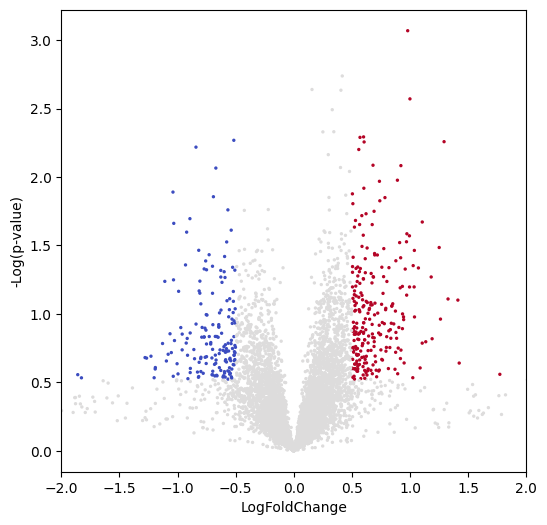

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (6,6))

volcano_df = adata.uns['rank_genes_groups_df']['Infected']

volcano_df['x'] = volcano_df['logfoldchanges']
volcano_df['y'] = -1 * np.log10(volcano_df['pvals'])

p_value_cut_off = 0.3
y_cut_off = -1 * np.log10(p_value_cut_off)

volcano_df['type'] = 0
volcano_df.loc[(volcano_df['x'] < -0.5)&(volcano_df['y'] > y_cut_off), 'type'] = -1
volcano_df.loc[(volcano_df['x'] > 0.5)&(volcano_df['y'] > y_cut_off), 'type'] = 1

ax.scatter(volcano_df['x'], volcano_df['y'], s = 2, c = volcano_df['type'], cmap='coolwarm')

ax.set_xlim(-2,2)

ax.set_xlabel('LogFoldChange')
ax.set_ylabel('-Log(p-value)')

#fig.savefig('./volcano.pdf')

In [12]:
PRO_list = volcano_df.loc[volcano_df['type']!=0, ].index

len(PRO_list)

442

## query protein interaction

In [19]:
query_df = BRICK.qr.query_relation(PRO_list, source_entity_type='Protein', relation='activate')
query_df.drop_duplicates(['path.0.name', 'path.2.name'], inplace=True)
nxg = BRICK.pp.df2nxg(query_df)

In [20]:
for n in nxg.nodes:
    nxg.nodes[n]['name'] = n

In [21]:
nt = BRICK.pl.interact_visualize_network(nxg)
nt.show('ppi.html')

nx.html
ppi.html


## Interprete analysis result

In [18]:
BRICK.inp.interpret_results(task='protein-protein interact predict', predict_PPI_pair = nxg.edges)

"### 1. Reasoning the Analysis Result\n\n- **Key Evidence Chain and Statistical Significance:**\n  - The predicted protein-protein interaction (PPI) pairs, such as ('BRCA1', 'HSPA5'), ('BRCA1', 'TP53BP1'), and ('HDAC1', 'NOS3'), are supported by the computational model used for prediction. The statistical significance of these predictions can be inferred from the confidence scores or p-values, which should be provided in the analysis.\n  - The presence of self-interactions (e.g., ('ESAM', 'ESAM'), ('FGFR1', 'FGFR1')) suggests that the model may also predict homodimers, which is a common biological phenomenon.\n\n- **Reasonability of the Analysis Result:**\n  - The predicted PPIs include well-known interactions, such as BRCA1 with TP53BP1, which are involved in DNA damage response and repair. This supports the reasonability of the analysis.\n  - The interaction between HDAC1 and NOS3 is plausible, given their roles in gene regulation and vascular function, respectively.\n  - The high fr